# FERS Tutorial Notebook
This notebook presents a tutorial to get FERS noobs up and running quickly.

It is assumed that you are running FERS locally, i.e. `fers` can be run from anywhere in your terminal. Feel free to use the server.sh file if you have a remote setup.

First, import some important modules.

In [1]:
import os
import numpy as np

from numpy import matlib as mb

### Define Simulation Parameters

In [2]:
c = 299792458
center_frequency = 2.4e9
wavelength = c/center_frequency

adc_rate = 100e6
over_sample_factor = 5

prf = 1000 # Hz
ramp_period = 1/prf
ramp_bandwidth = 50e6
simulation_sample_rate = adc_rate * over_sample_factor


### Create a Signal

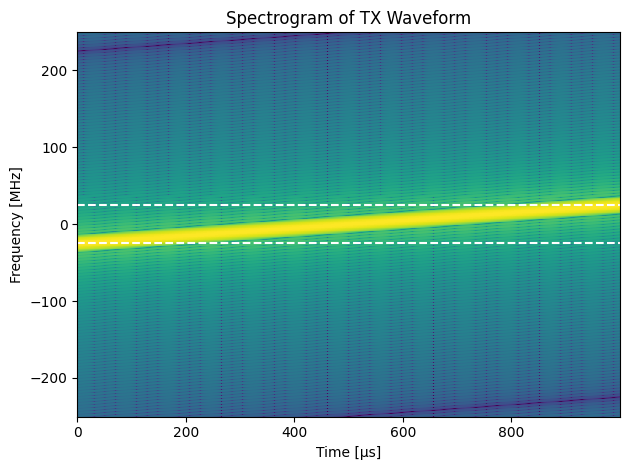

In [3]:
import fersxml as fersxml
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import spectrogram

# Generate and plot chirp
tx_chirp = fersxml.SignalGenerator.generate_chirp(ramp_period,simulation_sample_rate, ramp_bandwidth)
f, t, spect = spectrogram(tx_chirp,fs=simulation_sample_rate,nperseg=128,nfft=512,noverlap=0,mode='magnitude',window='blackman',return_onesided=False,detrend=False)

spect = 20*np.log10(np.abs(spect))
spect -= spect.max()

spect = np.fft.fftshift(spect, axes=0)
t *= 1e6
f = np.fft.fftshift(f)/1e6

# PLot the figure
plt.figure()
plt.hlines(ramp_bandwidth/2e6, t[0], t[-1], linestyles='--', colors='white')
plt.hlines(-ramp_bandwidth/2e6, t[0], t[-1], linestyles='--', colors='white')
plt.pcolormesh(t, f, spect)
plt.title('Spectrogram of TX Waveform')
plt.xlabel('Time [µs]')
plt.ylabel('Frequency [MHz]')
plt.tight_layout()

And write it to a file if you want

In [4]:
file_name = "lfm_transmision.hdf5"
fersxml.SignalGenerator.write_hdf5(tx_chirp,file_name)

### Simulation Components:

Here we define components that shall be comprised into complete platforms. 

This includes: `simulation parameters`, `timers`, `antenna`, `waveforms`

In [5]:
import fersxml as fersxml

SimulationConfiguration = fersxml.SimulationConfiguration("test sim")
SimulationConfiguration.define_dtd_file("fers-xml.dtd")

# Define global level simulation parameters
SimulationConfiguration.set_simulaion_parameters("0", "5","299792458", "1", "2048000", "16")
SimulationConfiguration.set_export_options(xml="false",csv="false",binary="false",csvbinary="false")

# Define timing sources which may be used by platforms
SimulationConfiguration.define_timing_source("clock1","true","0","0","10000000","0","0","0","0")

# Define antennas which may be used by platforms
SimulationConfiguration.define_isotropic_antenna("iso1","0.9")
SimulationConfiguration.define_parabolic_antenna("para1","0.9", "1")



### Define Signal Used In Simulation

Use the named defined when writing hdf files

In [6]:
# Define signals which may be used by platforms
SimulationConfiguration.define_pulse("pulse1",file_name,"1", "1","1000000")

### Simulation Platforms

Here we define the platforms which shall operate in the simulations.

This includes: `transmitters`, `receivers`, `targets`

#### Targets

In [7]:
import fersxml as fersxml

# Add some static isotropic target
static_targets = []
static_targets.append(fersxml.SimpleStaticIsotropicTargetPlatform(platform_name="static_aircraft_1", target_name='Plane_Wings', x=2000, y=5000, z=0.1, rcs=50))
static_targets.append(fersxml.SimpleStaticIsotropicTargetPlatform(platform_name="static_aircraft_2", target_name='Plane_Wings', x=7000, y=1000, z=0.1, rcs=100))
static_targets.append(fersxml.SimpleStaticIsotropicTargetPlatform(platform_name="static_aircraft_3", target_name='Plane_Wings', x=6000, y=8000, z=1, rcs=100))

for static_target in static_targets:
    # Create a targ
    SimulationConfiguration.create_static_isotropic_target_platform(static_target.platform_name, static_target.target_name ,static_target.rcs,static_target.x,static_target.y,static_target.z)

# Add some isotropic moving targets
moving_targets = []
moving_targets.append(fersxml.SimpleMovingIsotropicTargetPlatform(platform_name="moving_aircraft_1", target_name='Plane_Wings', x=[3000,3400], y=[5000,5500], z=[1,100], t=[0,5], rcs=50))

for moving_target in moving_targets:
    SimulationConfiguration.create_moving_isotropic_target_platform(moving_target.platform_name, moving_target.target_name ,moving_target.rcs,moving_target.x,moving_target.y,moving_target.z,moving_target.t)

#### Receivers

In [8]:
SimulationConfiguration.create_static_receiver_platform("rx_platform_1", "rec1", "para1", "clock1", "false", "false", "0.000001", "0.01", "100", "100" ,"0","0","10", "0","0")
SimulationConfiguration.create_moving_receiver_platform("rx_platform_2", "rec2", "iso1", "clock1", "false", "false", "0.000001", "0.01", "100", "100" ,[9000, 11000],[9000, 11000],[0,10], [0,5],"0","0")

#### Transmitters

In [9]:
SimulationConfiguration.create_static_transmitter_platform("tx_platform_1", "tx1","pulse1","iso1","clock1","continuous","0","12000","8000","0","0","0")
SimulationConfiguration.create_moving_transmitter_platform("tx_platform_2", "tx2","pulse1","iso1","clock1","continuous","0",[9000, 11000],[9000, 11000],[0,10], [0,5],"0","0")

In [10]:
SimulationConfiguration.write_to_file("tmp.xml")

TypeError: a bytes-like object is required, not 'ElementTree'

### Run a Simulation

Define a couple of convenience functions.

In [11]:
def lin2db(lin):
    '''
    Conversion from linear to decibels.
    '''
    return 10*np.log10(lin)

def achirp(period, sample_rate, bandwidth, init_freq=0, tau=0, phi=0):
    '''
    Generate an analytic baseband chirp.
    '''
    ns_chirp = int(np.ceil(period*sample_rate))
    t_chirp = np.linspace(-period/2, period/2, ns_chirp, endpoint=False)
    return np.exp(1.j*(np.pi*bandwidth/(2*max(t_chirp))*pow((t_chirp - tau), 2) + 2*np.pi*init_freq*(t_chirp - tau) + phi))

def next_pow_two(number):
    '''
    Returns the next power of two.
    '''
    return int(pow(2, np.ceil(np.log2(number))))

Radar parameters are set next.

In [12]:
fc = 2.4e9
wavelength = c/fc
ramp_bandwidth = 50e6
adc_rate = 100e6
decimation_factor = 100
os_factor = 1
adc_bits = 14
rf_sim_rate = adc_rate * os_factor
tx_power = 10 # watt
noise_temp = 290
noise_density = BOLTZMANN * noise_temp # [W/Hz]

print('Noise density:', np.round(lin2db(noise_density) + 30, 2), '[dBm/Hz]')

prf = 1000 # Hz
ramp_period = 1/prf
bb_sample_rate = adc_rate/decimation_factor

n_pulses = int(prf*n_seconds)
ns_pulse = int(ramp_period*bb_sample_rate)
ns_fft = next_pow_two(ns_pulse)

# time axes
t_rf  = np.linspace(0, ramp_period, int(ramp_period*rf_sim_rate), endpoint=False)
t_adc = np.linspace(0, ramp_period, int(ramp_period), endpoint=False)
t_bb = np.linspace(0, ramp_period, int(ramp_period*bb_sample_rate), endpoint=False)

f_fft = np.linspace(-bb_sample_rate/2, bb_sample_rate/2, ns_fft, endpoint=False)
r_fft = ramp_period/ramp_bandwidth * c/2 * f_fft

if (rf_sim_rate < ramp_bandwidth):
    print("Simulation sample rate insufficient, increase the over-sampling factor.")
    exit()

NameError: name 'BOLTZMANN' is not defined

Generate the FERS XML file and run the simulation.

In [ ]:
output_dir = os.path.abspath(os.getcwd())

fers.write_hdf5(tx_chirp, os.path.join(output_dir, FERS_INPUT_FILENAME))

fers_xml = fers.FersXMLGenerator(os.path.join(output_dir, FERS_XML_FILENAME))

fers_xml.add_parameters(
    t_start=1/prf,
    t_end=n_seconds,
    sim_rate=rf_sim_rate,
    bits=adc_bits
    )

fers_xml.add_pulse(
    name='up_chirp',
    pulse_file=FERS_INPUT_FILENAME,
    power_watts=tx_power,
    centre_freq=fc
    )

fers_xml.add_clock(name='clock', frequency=adc_rate, synconpulse='false')

fers_xml.add_antenna(name='tx_rx_antenna', pattern='isotropic')
# fers.add_antenna(name='tx_rx_antenna', pattern='parabolic', d=0.1)
# fers.add_antenna(name='tx_rx_antenna', pattern='sinc', a=pow(10, ANTENNA_GAIN/10), b=2, g=5, is_plot=True)

fers_xml.add_pseudo_monostatic_radar(
    spacing=antenna_spacing,
    waypoints=waypoints,
    antenna='tx_rx_antenna',
    timing='clock',
    prf=prf,
    pulse='up_chirp',
    window_length=ramp_period,
    noise_temp=noise_temp,
    nodirect='true'
)

for target in targets:            
    fers_xml.add_target(
        name = target.name,
        x = target.x,
        y = target.y,
        z = target.z,
        t = target.t,
        rcs = target.rcs
    )

fers_xml.write_xml()
fers_path = "../build/src/fers"
fers_xml.run(fers_path)
del fers_xml

rx_matrix = fers.read_hdf5(FERS_OUTPUT_FILENAME)

../build/src/fers


/------------------------------------------------\
| FERS - The Flexible Extensible Radar Simulator |
| Version 0.28                                   |
\------------------------------------------------/

[VERBOSE] Loading XML Script File.
[CRITICAL] Propagation speed (c) set to custom value: 299792458.00000
[VV] System sample rate set to custom value: 100000000.00000
[VERBOSE] Using random seed from clock(): 1711900984
[VERBOSE] Quantizing results to 14 bits
[VV] Oversampling enabled with ratio 1
[VV] Generating Pulse up_chirp of type 'file'
[VV] Loading antenna 'tx_rx_antenna' of type 'isotropic'
[VV] Loading timing source 'clock'
[VV] Loading Transmitter: 0
[VV] Loading Receiver: 'receiver' 0
[VV] Ignoring direct signals for receiver 'receiver'
[INFO] Using threaded simulation with 8 threads.
[VERBOSE] Created simulator thread for transmitter 'transmitter' and receiver 'receiver' 1000
[VV] 3000 responses added to receiver 'receiver'
[VV] Created render thread for receiver 'receiver'

Perform RF dechirp by mixing RX and DX and filtering result.
Analytic representation eliminates need to filter.

In [ ]:
# dx_chirp is a row vector -> repeat over several rows
# now rx_matrix and dx_matrix both have pulses as rows (axis = 1)
dx_matrix = mb.repmat(tx_chirp, n_pulses, 1)

bb_matrix = np.multiply(dx_matrix, np.conjugate(rx_matrix))
# del rx_matrix, dx_matrix

Decimate the data to the final sample rate.

In [ ]:
# decimate to ADC rate
bb_matrix = decimate(bb_matrix, os_factor, axis=1, zero_phase=True)
# decimate to final sample rate
bb_matrix = decimate(bb_matrix, decimation_factor, ftype='fir', axis=1)

: 

Transpose the data matrix for pulses down each column.

In [ ]:
bb_matrix = np.transpose(bb_matrix)

Plot the time domain beat signal.

In [ ]:
plt.figure()
plt.plot(t_bb*1e6, bb_matrix[:, 0])
plt.xlabel('Time (us)')

Apply a window of your choice to the time domain beat signal.

In [ ]:
window_matrix = np.blackman(ns_pulse)

window_matrix = np.transpose(
    np.tile(window_matrix, (n_pulses, 1)))

bb_matrix = np.multiply(bb_matrix, window_matrix)

Take FFT of each beat signal.

In [ ]:
bb_matrix = np.fft.fftshift(np.fft.fft(
    bb_matrix, ns_fft, axis=0), axes=0)

Plot a range profile of the pulse in the middle of the experiment.

In [ ]:
plt.figure()
plt.plot(r_fft, lin2db(abs(bb_matrix[:, n_pulses//2])))
plt.xlim(0, r_fft[-1])
plt.grid()
plt.xlabel('Range (m)')

Generate a range-time-intensity plot of the data matrix.

In [ ]:
image_axes = [0, n_seconds, r_fft[-1], r_fft[0]]

fig, ax = plt.subplots(nrows=1, ncols=1)
im = ax.imshow(
    lin2db(abs(bb_matrix)),
    aspect='auto',
    # vmax=vmax,
    # vmin=vmin,
    interpolation='none',
    # cmap=cmap,
    extent=image_axes,
)
ax.set_ylim(0, r_fft[-1])
ax.set_xlabel('Time (s)')
ax.set_ylabel('Range (m)')
# ax.grid()